## REI602M Machine Learning - Project 1
### Due: *Friday* 20.04.2018

**Objectives**: Allstate Claims Severity

**Name**: Þór Tómasarson, **email: ** tht33@hi.is, **collaborators:** Eggert Jón Magnússon

In [193]:
import time
import numpy as np
import pandas as pd
pd.options.display.float_format = '{:,.3f}'.format

# %matplotlib notebook
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

### Preprocess the data

In [168]:
train = pd.read_csv('train.csv', delimiter=',', index_col='id')
X_train, y_train = train.loc[:, train.columns != 'loss'], train['loss']

In [169]:
# Split train - test
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.30)
X_train_origin, y_train_origin = X_train.copy(), y_train.copy()

X_train.describe()

,cont1,cont2,cont3,cont4,cont5,cont6,cont7,cont8,cont9,cont10,...,cat116_P,cat116_Q,cat116_R,cat116_S,cat116_T,cat116_U,cat116_V,cat116_W,cat116_X,cat116_Y
count,"131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000",...,"131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000","131,822.000"
mean,0.494,0.507,0.499,0.492,0.487,0.491,0.485,0.487,0.485,0.498,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
std,0.188,0.207,0.202,0.211,0.209,0.205,0.178,0.200,0.182,0.186,...,0.004,0.004,0.005,0.004,0.003,0.009,0.000,0.003,0.004,0.009
min,0.000,0.001,0.003,0.177,0.281,0.013,0.070,0.237,0.000,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,0.346,0.358,0.337,0.327,0.281,0.336,0.350,0.313,0.359,0.365,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
50%,0.476,0.556,0.528,0.453,0.422,0.441,0.438,0.441,0.439,0.461,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
75%,0.624,0.682,0.634,0.652,0.635,0.654,0.591,0.624,0.561,0.615,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
max,0.985,0.863,0.944,0.952,0.984,0.997,1.000,0.980,0.995,0.995,...,1.000,1.000,1.000,1.000,1.000,1.000,0.000,1.000,1.000,1.000


No need to transform any of the continuous attributes. They are all on the interval [0, 1] with reasonable standard deviation, also there are no missing values for the continuous attributes.

The **loss** column has the following statistics {mean: 3037.3, std: 2904.1, min: 0.67, max: 121012.25}. With $min\approx0$, $mean \approx std$ and $max>>std$ $\frac{max}{std}=\frac{121012.25}{2904.1}=41.67$, these numbers indicate a highly skewed data with long tail to the right.

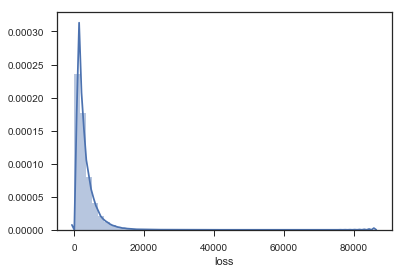

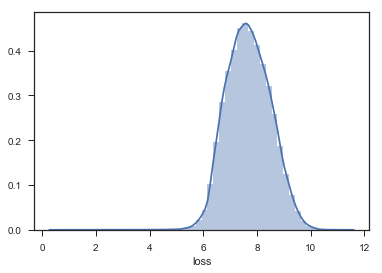

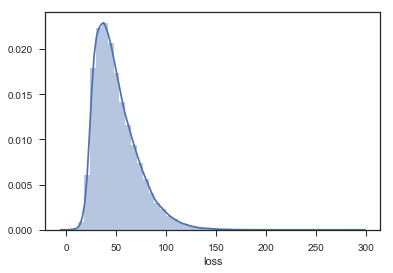

In [76]:
sns.distplot(y_train)
plt.show()

sns.distplot(np.log1p(y_train))
plt.show()

In [191]:
y_train = np.log1p(y_train)

The former plot confirms the theory of skewness. With a $log(x + 1)$ transform the **loss** column looks more like the expected (at least for Linear Regression) Gaussian distribution. The $+1$ in $log(x + 1)$ is just to be on the safe side of the floating point cancellation, even though the data indicates that there should not be a need for it (with min $0.67 >> 0$ "in some sense").

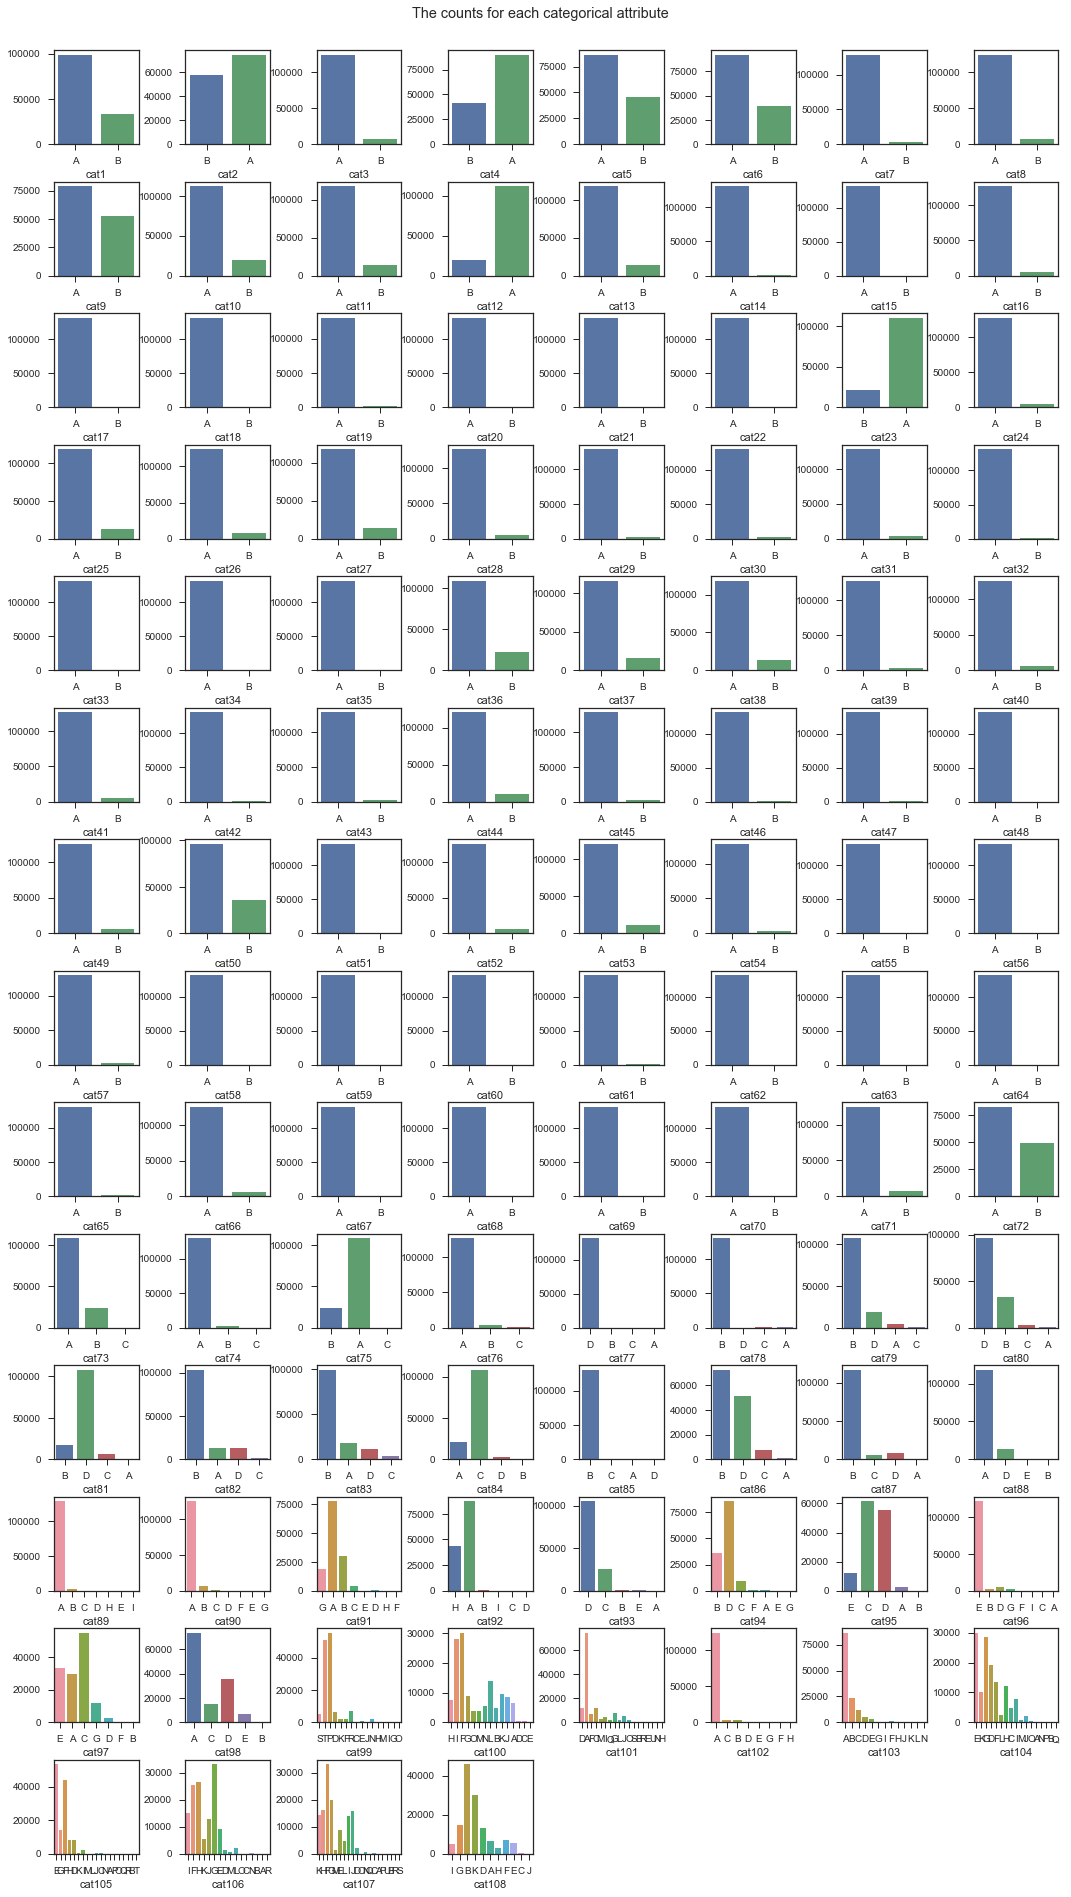

In [119]:
# Count the number of items for each categorical attribute
cat_index = [x for x in X_train.columns if x.startswith('cat')]
X_train[cat_index].describe(include = 'all')

n = 8
r = len(cat_index)//n
plt.figure(figsize=(18, 30))
for i in range(r):
    for j in range(n if i != r-1
                     else ((len(cat_index)%n))
                  ):
        plot = plt.subplot(r, n, (i*n + j + 1))
        # sns.boxplot(x=features[axIndex], y="loss", data=train_data, ax=axList[axIndex])
        ax = sns.countplot(x=cat_index[i*n + j], data=X_train)
        plt.subplots_adjust(wspace=0.55, hspace=0.4, top=0.96)
        ax.set_ylabel('')
plt.suptitle('The counts for each categorical attribute')
plt.show()

There are few categorical attributes that have next to no distribution, that is to say all values have the same label except very few. These few items could be a rare event but they could also be "uninteresting" and then consequently will increase the number of attributes without the need for it, which could damage the performance for some of the models. In order to be able to distinguish between whether these are rare events or "uninteresting" then we would need to know the true nature of these attributes (would need have the field knowledge).

Since we can not know what these attributes represent then for safety measures we keep them all when performing the one-hot encoding.

In [155]:
# One-hot transform
X_train = pd.get_dummies(X_train, drop_first=True)

# drop_first is crucial to avoid correlation in these features
# See this example:
# df = pd.DataFrame(data={'Sex': ['M', 'F', 'F', 'B'], 'Married': ['Yes', 'Yes', 'No', 'No']})
# pd.get_dummies(df, drop_first=True) # VS. drop_first=false

Correlations:
      cont1  cont10  cont11  cont12  cont13  cont14  cont2  cont3  cont4  \
loss -0.011   0.019   0.097   0.096  -0.005   0.020  0.142  0.111 -0.036   

      cont5  cont6  cont7  cont8  cont9  
loss -0.012  0.039  0.117  0.030  0.014  


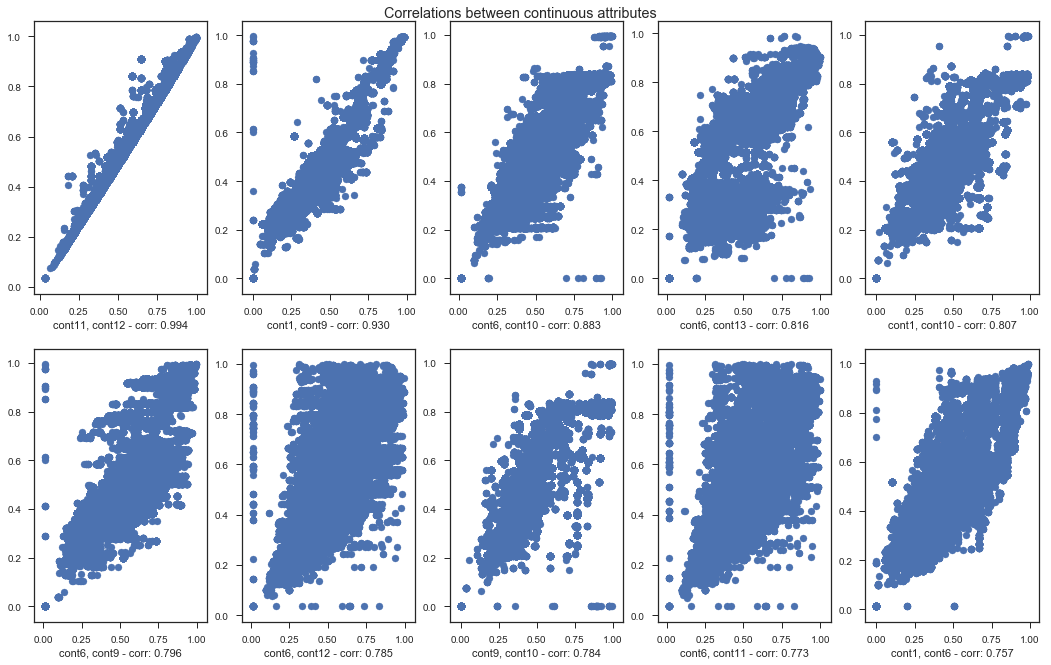


There are 10 correlated features with (absolute) correlation higher than 0.75


In [139]:
cont_index = lambda : [x for x in X_train.columns if x.startswith('cont')]

print('Correlations:')
corr = {}
corr_cont_loss = {}
for idx, col_1 in enumerate(cont_index()):
    corr[(col_1, 'loss')] = X_train[col_1].corr(y_train)
    corr_cont_loss[col_1] = corr[(col_1, 'loss')]
    
    for col_2 in cont_index()[idx+1:]:
        if col_1 != col_2:
            corr[(col_1, col_2)] = X_train[col_1].corr(X_train[col_2])
print(pd.DataFrame(data=corr_cont_loss, index=['loss']))
            
limit = 0.75
correlated = {}
for key, value in corr.items():
    if np.abs(value) > limit:
        correlated[key] = value

import operator
correlated = sorted(correlated.items(), key=operator.itemgetter(1))
correlated.reverse()

plt.figure(figsize=(18, 10))
i = 0
for key, value in correlated:
    plot = plt.subplot(2, 5, i + 1)
    plt.scatter(X_train[key[0]], X_train[key[1]])
    # ax = sns.jointplot(x=key[0], y=key[1], data=X_train)
    plot.set_xlabel(f'{key[0]}, {key[1]} - corr: {value:.3f}')
    plt.subplots_adjust(top=0.96)
    i += 1
plt.suptitle('Correlations between continuous attributes')
plt.show()

print(f'\nThere are {len(correlated)} correlated features with (absolute) correlation higher than {limit}')

There is no single continuous attribute with high correlation with the output (loss - attribute).

There are 10 correlated pairs (correlation > 0.75) out of the 14x14 combinations of the continuous attributes. The correlation is high and visible for {cont1-cont9, cont6-cont10, cont1-cont10, cont6-cont9, cont9-cont10, cont1-cont6} and extremely high for {cont11-cont12}. This indicates that PCA could be very useful, or one could even consider dropping the following attributes {cont12, cont6, cont9, cont10}. Thus reducing the number of continuous attributes down to 10 attributes.

In [170]:
X_train.drop(['cont12', 'cont6', 'cont9', 'cont10'], axis=1, inplace=True)
X_test.drop(['cont12', 'cont6', 'cont9', 'cont10'], axis=1, inplace=True)

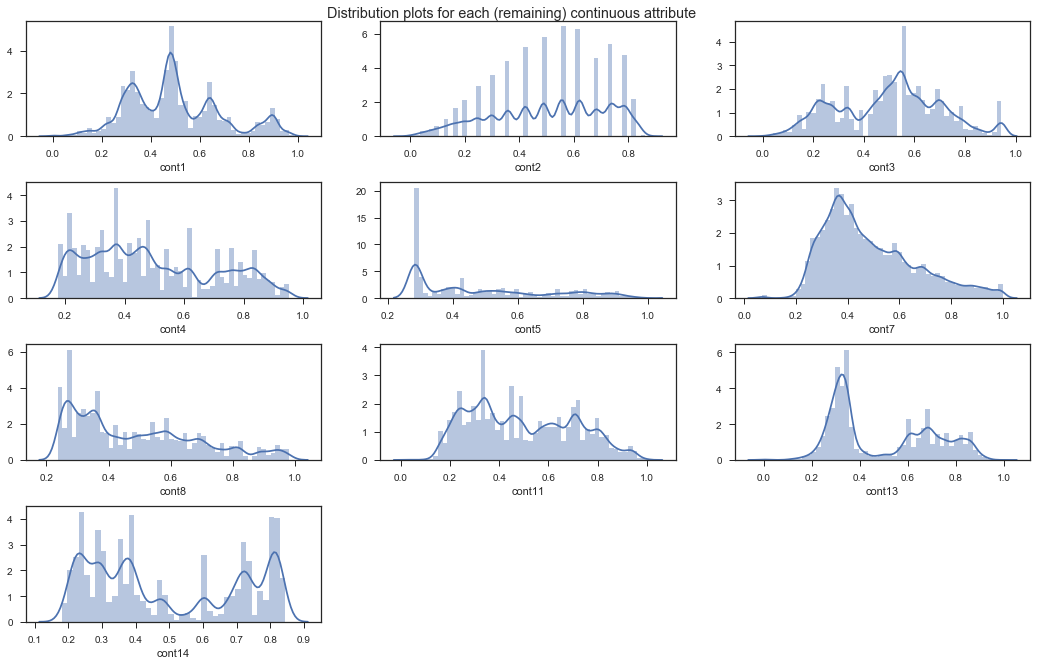

In [163]:
plt.figure(figsize=(18, 10))

n = len(cont_index())
for i, col in enumerate(cont_index()):
    plot = plt.subplot(n//3+1, 3, i + 1)
    sns.distplot(X_train[col])
    plot.set_xlabel(f'{col}')
    plt.subplots_adjust(hspace=0.4, top=0.96)
plt.suptitle('Distribution plots for each (remaining) continuous attribute')
plt.show()

In [190]:
# TOOD: Apply the same function on both the test and train datasets
def preprocess_data(X, y):
    pass

# X_train_changed = X_train.copy()
# X_train, y_train = preprocess_data(X_train_origin, y_train_origin)
# assert X_train == X_train_changed

# X_test, y_test = preprocess_data(X_test, y_test)
n_train, m_train = X_train.shape
n_test, m_test = X_test.shape

# TODO: Delete this..
y_test = np.log1p(y_test)

In [194]:
# Fit estimators
ESTIMATORS = {
    # Linear: (Run with PCA (or PCA->30->t-SNE) and non-negative)
    "LinearRegression": LinearRegression(n_jobs=-1),
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.001),
    # non-linear
    "KNeighborsRegressor": KNeighborsRegressor(n_neighbors=1, n_jobs=-1),
    "SVR": SVR(),
    "BaggingRegressor": BaggingRegressor(n_jobs=-1),
    "RandomForestRegressor": RandomForestRegressor(n_jobs=-1, n_estimators=50),
    "ExtraTreesRegressor": ExtraTreesRegressor(n_jobs=-1, n_estimators=100),
}

y_test_predict = dict()
for name, estimator in ESTIMATORS.items():
    t_0 = time.time()
    print(f'{name}:')
    estimator.fit(X_train, y_train)
    
    t_1 = time.time()
    print(f'\tTime elapsed for fitting of model {t_1 - t_0:.3f} sec')
#     if name == "K-nn":
#         sub_idx = np.random.permutation(n_test) #[:1000]    # TODO: Maybe increase this
#         y_test_predict[name] = estimator.predict(X_test.values[sub_idx, :])
#         error = mean_absolute_error(y_test.values[sub_idx], y_test_predict[name]) # TODO: Add np.expm1(..
#     else:
    y_test_predict[name] = estimator.predict(X_test)
    error = mean_absolute_error(y_test, y_test_predict[name]) # TODO: Add np.expm1(..
    print(f'\tTime elapsed for prediction {time.time() - t_1:.3f} sec')
    print(f'\tError: {error:.3f}')
    
# This here is with no log-transform

LinearRegression:
	Time elapsed for fitting of model 24.355 sec
	Time elapsed for prediction 0.434 sec
	Error: 1655603234.882
Ridge:
	Time elapsed for fitting of model 5.799 sec
	Time elapsed for prediction 0.414 sec
	Error: 1302.587
Lasso:


C:\Users\Notandi\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


	Time elapsed for fitting of model 200.994 sec
	Time elapsed for prediction 0.426 sec
	Error: 1305.573
KNeighborsRegressor:
	Time elapsed for fitting of model 95.604 sec
	Time elapsed for prediction 4662.196 sec
	Error: 1747.104
SVR:
	Time elapsed for fitting of model 20007.080 sec
	Time elapsed for prediction 10160.075 sec
	Error: 1755.613
BaggingRegressor:
	Time elapsed for fitting of model 134.787 sec
	Time elapsed for prediction 12.849 sec
	Error: 1295.292
RandomForestRegressor:
	Time elapsed for fitting of model 475.075 sec
	Time elapsed for prediction 1.643 sec
	Error: 1245.477
ExtraTreesRegressor:
	Time elapsed for fitting of model 1922.238 sec
	Time elapsed for prediction 3.084 sec
	Error: 1281.961
